Epoch 0, Loss: 19829750.0
Epoch 500, Loss: 19894022.0


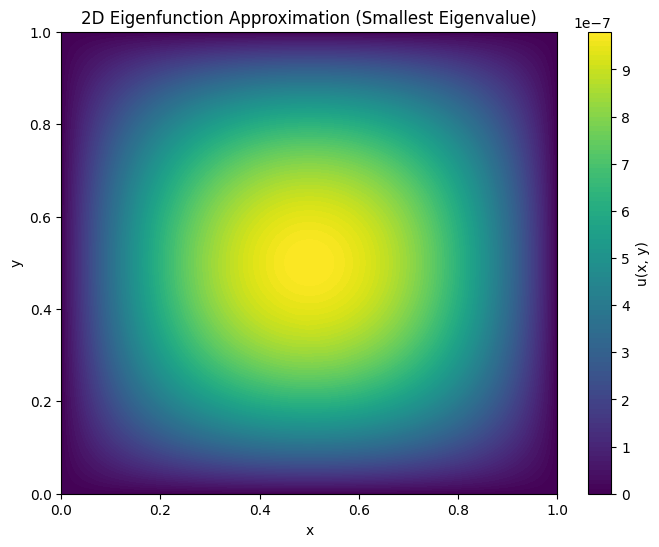

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 8)
        self.fc9 = nn.Linear(8, 4)
        self.fc10 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        x = self.fc10(x)
        return x

# Initialize neural network
model = NeuralNet().to(device)

# Define the trial function to enforce boundary conditions
def trial_solution(xy, u_pred):
    x = xy[:, 0]
    y = xy[:, 1]
    return (1 - x) * (1 - y) * x * y * u_pred  # Ensures u=0 at the boundary

# Define the PDE residual for the eigenvalue problem: Δu = λu
def pde_residual(xy, u_pred, eigenvalue):
    u_trial = trial_solution(xy, u_pred)

    # Compute first and second derivatives with respect to x and y
    u_x = grad(u_trial, xy, grad_outputs=torch.ones_like(u_trial), create_graph=True)[0][:, 0]
    u_y = grad(u_trial, xy, grad_outputs=torch.ones_like(u_trial), create_graph=True)[0][:, 1]

    u_xx = grad(u_x, xy, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = grad(u_y, xy, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]

    # PDE residual: Δu - λu = u_xx + u_yy - λu
    pde_res = u_xx + u_yy - eigenvalue * u_trial

    # Mean squared residual
    return torch.mean(pde_res**2)

# Define the Rayleigh quotient loss function with normalization
def rayleigh_quotient_loss(xy, u_pred):
    u_trial = trial_solution(xy, u_pred)

    # Compute gradients for u_x and u_y
    u_x = grad(u_trial, xy, grad_outputs=torch.ones_like(u_trial), create_graph=True)[0][:, 0]
    u_y = grad(u_trial, xy, grad_outputs=torch.ones_like(u_trial), create_graph=True)[0][:, 1]

    # Compute energy integral: integral of (u_xx + u_yy)^2
    energy_integral = torch.mean(u_x**2 + u_y**2)

    # Compute mass integral: integral of u^2
    mass_integral = torch.mean(u_trial**2)

    # Rayleigh quotient for smallest eigenvalue
    rayleigh_loss = energy_integral / mass_integral

    # Normalize the solution to avoid trivial solution
    normalization_term = (mass_integral - 1)**2  # Enforce non-trivial normalization

    return rayleigh_loss + normalization_term

# Define the Rayleigh quotient loss function with normalization
def Eval(xy, u_pred):
    u_trial = trial_solution(xy, u_pred)

    # Compute gradients for u_x and u_y
    u_x = grad(u_trial, xy, grad_outputs=torch.ones_like(u_trial), create_graph=True)[0][:, 0]
    u_y = grad(u_trial, xy, grad_outputs=torch.ones_like(u_trial), create_graph=True)[0][:, 1]

    # Compute energy integral: integral of (u_xx + u_yy)^2
    energy_integral = torch.mean(u_x**2 + u_y**2)

    # Compute mass integral: integral of u^2
    mass_integral = torch.mean(u_trial**2)

    # Rayleigh quotient for smallest eigenvalue
    rayleigh_loss = energy_integral / mass_integral

    return rayleigh_loss

# Define the combined loss function (PINN loss + boundary loss + normalization)
def total_loss(xy, xy_bc, u_pred, u_pred_bc, eigenvalue):
    # Boundary condition loss (enforcing u=0 on the boundary)
    bc_loss = torch.mean(u_pred_bc**2)

    # PDE residual loss (PINN loss)
    pde_loss = pde_residual(xy, u_pred, eigenvalue)

    # Rayleigh loss (with normalization)
    rayleigh_loss = rayleigh_quotient_loss(xy, u_pred)

    return pde_loss + bc_loss + rayleigh_loss

# Training data: sample points in the domain [0, 1] x [0, 1]
N_train = 1000
x_train = np.random.rand(N_train, 2)
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).to(device)

# Boundary points
N_bc = 200
x_bc = np.concatenate([np.random.rand(N_bc, 2) * [1, 0],  # y=0
                       np.random.rand(N_bc, 2) * [1, 0] + [0, 1],  # y=1
                       np.random.rand(N_bc, 2) * [0, 1],  # x=0
                       np.random.rand(N_bc, 2) * [0, 1] + [1, 0]])  # x=1
x_bc = torch.tensor(x_bc, dtype=torch.float32, requires_grad=True).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass: predict u for training points and boundary points
    u_pred = model(x_train)
    u_pred_bc = model(x_bc)

    # Eigenvalue guess (can be refined during training)
    eigenvalue = Eval(x_train,u_pred)

    # Compute total loss (PINN loss + boundary loss + normalization)
    loss = total_loss(x_train, x_bc, u_pred, u_pred_bc, eigenvalue)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss and eigenvalue (Rayleigh quotient) every 500 epochs
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate 2D plot of the solution
x_plot = np.linspace(0, 1, 100)
y_plot = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_plot, y_plot)
xy_plot = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float32, requires_grad=True).to(device)

# Predict u for the entire grid
with torch.no_grad():
    u_plot = model(xy_plot).cpu().numpy().reshape(100, 100)

# Apply trial solution to ensure boundary conditions are enforced
u_trial_plot = (1 - X) * (1 - Y) * X * Y * u_plot

# Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_trial_plot, levels=100, cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.title('2D Eigenfunction Approximation (Smallest Eigenvalue)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()